``lux.ai - Curso de Fotografia Computacional - Aprendizado de Máquina e Profundo``

---

# **Classificação com MLP em PyTorch**

---

Já utilizamos uma rede **MLP** para fazer a classificação de dígitos com *Scikit Learn*. Também realizamos testes com nosso modelo em dados advindos do *PyTorch*.
Nesse colab vamos utilizar uma **MLP** novamente para realizar a classficação de roupas utilizando o *PyTorch* para treinamento no dataset *FashionMNIST*.

```OBS: Quando pedido, realize a operação na célula correspondente atribuindo o resultado na variável indicada. Não altere os nomes das variáveis utilizadas. Você pode utilizar célularsadicionais para realizar testes, utilizando variáveis auxiliares para visualizar resultados intermediários.```

---
## **01 - Imports**
---

In [ ]:
%%capture
%!pip install torchsummary

# Modelagem e dados
import torch
from torchvision import transforms, datasets
from torch import nn, optim
from torch.utils.data import random_split, DataLoader


# Avaliação de modelos
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# Plotting e visualização
from torchsummary import summary
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

---
## **02 - Datasets e DataLoaders**
---

Utilizaremos o dataset *FashionMNIST*, que é composto por $70000$ imagens no formato $28 \times 28$ caracterizando um problema de classificação de imagens em tons de cinza de diferentes roupas e calçados.

In [ ]:
print(datasets.FashionMNIST.__doc__)

`Fashion-MNIST <https://github.com/zalandoresearch/fashion-mnist>`_ Dataset.

    Args:
        root (string): Root directory of dataset where ``FashionMNIST/raw/train-images-idx3-ubyte``
            and  ``FashionMNIST/raw/t10k-images-idx3-ubyte`` exist.
        train (bool, optional): If True, creates dataset from ``train-images-idx3-ubyte``,
            otherwise from ``t10k-images-idx3-ubyte``.
        download (bool, optional): If True, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
    


### **Q1**

O *FashionMNIST* possui apenas um partição de treino e uma de teste:
 - Utilize o padrão do `train_ds` para gerar o `test_ds`;
 - Divida o `train_ds` gerando um `valid_ds` com `15%` dos dados utilizando o método `data.random_split`.

Referência:
 - [Datasets e DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

In [ ]:
transform = transforms.ToTensor()

train_ds = datasets.FashionMNIST(
    root = ".",
    train = True,
    download = True,
    transform = transform
)

test_ds  = datasets.FashionMNIST(
    root = ".",
    train = False,
    download = True,
    transform = transform
)

train_ds, valid_ds = random_split(train_ds, [0.85,0.15])

### **Q2**

Crie os *DataLoaders* para os conjuntos de validação, treino e teste:
 - Utilize os *batches* de treino, validação e teste como `128`.
 - Defina o `num_workers` como `2` e mantenha o `shuffle` e `pin_memory` habilitado (`True`).

In [ ]:
train_dl = DataLoader(train_ds, batch_size=128, num_workers=2, shuffle=True, pin_memory=True)

test_dl  = DataLoader(test_ds, batch_size=128, num_workers=2, shuffle=True, pin_memory=True)

valid_dl = DataLoader(valid_ds, batch_size=128, num_workers=2, shuffle=True, pin_memory=True)

---
## **03 - Visualização dos Dados**
---

In [ ]:
samples, targets = next(iter(test_dl))
print(samples.shape, targets.shape)

torch.Size([128, 1, 28, 28]) torch.Size([128])


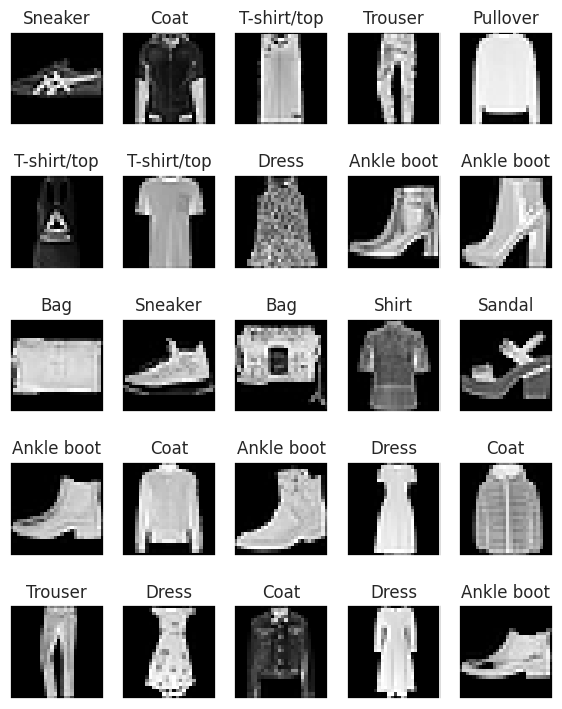

In [ ]:
w = 5
fig, ax = plt.subplots(w, w, figsize=(7, 9))
for i in range(w):
    for j in range(w):
        ax[i][j].imshow(samples[i * w + j].permute(1, 2, 0), cmap="gray", interpolation="None")
        label = targets[i * w + j].item()
        ax[i][j].set_title(test_ds.classes[int(label)])
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])

---
## **04 - Criação do Modelo**
---


### **Q3**

Crie a classe `MyMLP` que herda de `nn.Module`, essa classe deve conter em sequência:

1. *Uma camada linear de dimensão* `(in=n, out=256)` (`nn.Linear`);
2. *Ativação ReLU* (`nn.ReLU`);
3. *Uma camada linear de dimensão* `(in=256, out=o)`.

> Lembrando que `n` é a dimensão da entrada $28 \times 28$. Para a **MLP** precisamos redimensionar a entrada para um vetor unidimensional utilizando a função `nn.Flatten()` antes de passar pela camada linear.

> `o` deve ser o número de classes que queremos classificar, ou seja, $10$.
Defina o modelo de tal forma que possamos instanciá-lo como `MyMLP(n, o)`.

> Note que todo modelo do *PyTorch* deve conter o método `__init__` onde criamos as camadas e o `forward` onde realizamos a inferência.

> A segunda camada linear não possuirá ativação, vamos retornar o vetor de predição diretamente.

Seu modelo deve ser parecido com o seguinte resultado:

```
MyMLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (mlp): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=10, bias=True)
  )
)
```

Referências:

- [Gerando Modelos](https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html)

- [nn.Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html)

- [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)

- [nn.ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)

In [ ]:
class MyMLP(nn.Module):
    def __init__(self, n, o):
        super().__init__()
        self.flatten = nn.Flatten()
        self.mlp = nn.Sequential(
            nn.Linear(n, 256),
            nn.ReLU(),
            nn.Linear(256, o)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.mlp(x)
        return logits


model = MyMLP(28*28,10).to(DEVICE)
print(model)

MyMLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (mlp): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [ ]:
summary(model, input_size=(1,28,28), batch_size=128, device=DEVICE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [128, 784]               0
            Linear-2                 [128, 256]         200,960
              ReLU-3                 [128, 256]               0
            Linear-4                  [128, 10]           2,570
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 1.28
Params size (MB): 0.78
Estimated Total Size (MB): 2.43
----------------------------------------------------------------


---
## **05 - Loss e Otimização**
---

### **Q4**

Defina a função de *loss* utilizando o `nn.CrossEntropyLoss` e o otimizador como o `optim.Adam`. Utilize no *Adam* os parâmetros do seu modelo taxa de aprendizado igual `1e-4`.

Referências:

[Cross Entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

[Optimizers](https://pytorch.org/docs/stable/optim.html)

In [ ]:
loss_fn   = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=1e-4)

---
## **06 - Passos de Treinamento e Validação**
---

### **Q5**

Complete as funções `train_step` e `valid_step` para que possamos realizar a otimização e avaliação do modelo.

> Lembre de setar o modelo para cada passo de forma correta (e.g., `train` e `eval`).

> Os exemplos e as *labels* devem estar no mesmo `DEVICE` que o modelo.

In [ ]:
class AverageMeter:
    """Computes and stores the average and current value"""
    # Fonte: https://kaiyangzhou.github.io/deep-person-reid/_modules/torchreid/utils/avgmeter.html#AverageMeter
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def train_step(model, train_dl, loss_fn, optimizer, device):
    # Ativar modo de treino
    model.train()

    train_loss = AverageMeter()
    for train_instances, instance_labels in train_dl:

        # Mover os batches e as labels para o mesmo dispositivo do modelo
        train_instances = train_instances.to(device)
        instance_labels = instance_labels.to(device)

        # Realizar a previsão com o modelo
        logits = model(train_instances)

        # Zerar os gradientes para evitar acumulação
        optimizer.zero_grad()

        # Calcular o valor de loss
        loss = loss_fn(logits, instance_labels)
        train_loss.update(loss.item(), len(train_instances))

        # Backpropagation
        loss.backward()

        # Atualizar os parâmetros da rede
        optimizer.step()

    return train_loss.avg

In [ ]:
def validation_step(model, val_dl, loss_fn, device):
    # Ativar modo de avaliação
    model.eval()
    val_loss = AverageMeter()

    # Desativar a computação de gradientes
    with torch.no_grad():
        for val_instances, instance_labels in val_dl:
            # Mover os batches e as labels para o mesmo dispositivo do modelo
            val_instances = val_instances.to(device)
            instance_labels = instance_labels.to(device)

            # Realizar a previsão com o modelo
            logits = model(val_instances)

            # Calcular o valor de loss
            loss = loss_fn(logits, instance_labels)
            val_loss.update(loss.item(), len(val_instances))

    return val_loss.avg

---
## **07 - Treinamento do Modelo**
---


### **Q6**


Vamos executar o modelo utilizando o `train_step` e `valid_step` que definimos anteriormente. Complete o código abaixo para realizar o treinamento.

In [ ]:
history = {
    "train_loss": [],
    "val_loss": []
}

EPOCHS = 50 # Número de iterações

for epoch in range(EPOCHS):
    train_loss = train_step(model, train_dl, loss_fn, optimizer, DEVICE)
    val_loss   = validation_step(model, valid_dl, loss_fn, DEVICE)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)

    print(f"Epoch [{epoch + 1}/{EPOCHS}]")
    print("-" * 35)
    print(f"Train loss: {round(train_loss, 6):<7}")
    print(f"Valid. loss: {round(val_loss, 6):<7}\n")

Epoch [1/50]
-----------------------------------
Train loss: 1.032009
Valid. loss: 0.668853

Epoch [2/50]
-----------------------------------
Train loss: 0.597495
Valid. loss: 0.554454

Epoch [3/50]
-----------------------------------
Train loss: 0.519583
Valid. loss: 0.50802

Epoch [4/50]
-----------------------------------
Train loss: 0.481648
Valid. loss: 0.479012

Epoch [5/50]
-----------------------------------
Train loss: 0.455764
Valid. loss: 0.467982

Epoch [6/50]
-----------------------------------
Train loss: 0.439405
Valid. loss: 0.446131

Epoch [7/50]
-----------------------------------
Train loss: 0.425365
Valid. loss: 0.435927

Epoch [8/50]
-----------------------------------
Train loss: 0.414292
Valid. loss: 0.424965

Epoch [9/50]
-----------------------------------
Train loss: 0.404046
Valid. loss: 0.422781

Epoch [10/50]
-----------------------------------
Train loss: 0.394975
Valid. loss: 0.414967

Epoch [11/50]
-----------------------------------
Train loss: 0.388189

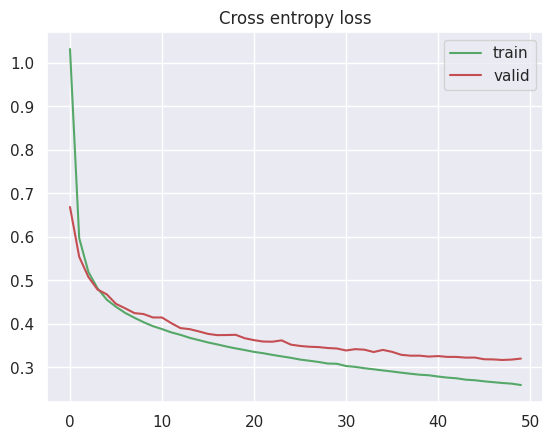

In [ ]:
fig = plt.figure()
plt.title("Cross entropy loss")
plt.plot(history["train_loss"], c="g", label="train")
plt.plot(history["val_loss"], c="r", label="valid")
plt.legend()

---
## **08 - Teste**
---

### **Q7**

Por fim, vamos avaliar nosso modelo no conjunto de teste:

- Defina o modelo como avaliação;
- Passe os exemplos para o dispositivo em uso;
- Realize a previsão com o modelo;
- Obtenha o vetor de probabilidades a partir da saída do modelo usando o `nn.functional.softmax`;
- Obtenha o índice (número da classe) que contém o valor máximo de probabilidade usando o `torch.argmax`.

In [ ]:
all_preds = []
all_targets = []

total_corrects = 0
total_n = 0

# Ativar modo de avaliação
model.eval()

for test_instances, instance_labels in test_dl:

    # Mover os batches e as labels para o mesmo dispositivo do modelo
    test_instances = test_instances.to(DEVICE)
    instance_labels = instance_labels.to(DEVICE)

    with torch.no_grad():
        # Realizar a previsão com o modelo
        logits = model(test_instances)

    # Obter o vetor de probabilidades
    probs = nn.functional.softmax(logits, 1)

    # Obter a classe com a probabilidade máxima
    preds = torch.argmax(probs, 1)

    total_corrects += (preds == instance_labels).sum().item()
    total_n += len(test_instances)

    all_preds.append(preds.unsqueeze(-1))
    all_targets.append(instance_labels.unsqueeze(-1))


preds = torch.cat(all_preds).squeeze(-1).cpu()
targets = torch.cat(all_targets).squeeze(-1).cpu()

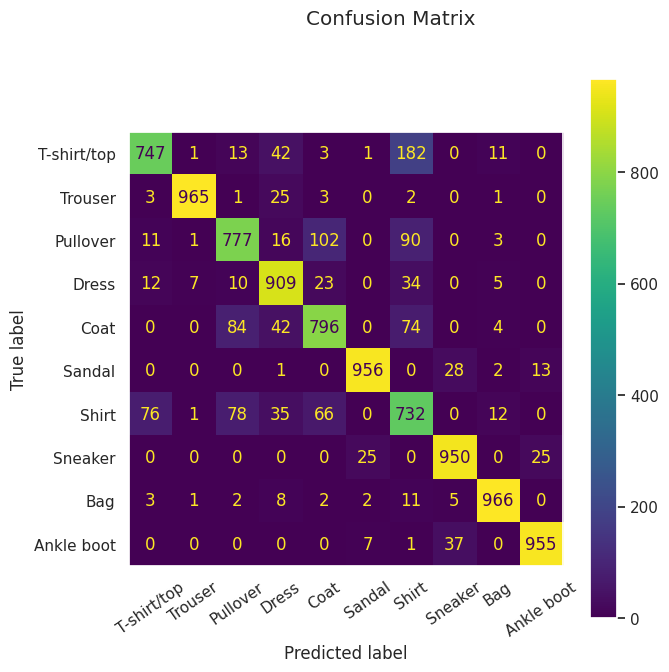

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
fig.suptitle("Confusion Matrix")
ax.grid(False)

labels = test_ds.classes

cm = confusion_matrix(targets, preds)
cm_display = ConfusionMatrixDisplay(cm, display_labels=labels)
cm_display.plot(ax=ax, xticks_rotation=35.0)

In [ ]:
print(classification_report(targets, preds, target_names=labels, zero_division=0))

              precision    recall  f1-score   support

 T-shirt/top       0.88      0.75      0.81      1000
     Trouser       0.99      0.96      0.98      1000
    Pullover       0.81      0.78      0.79      1000
       Dress       0.84      0.91      0.87      1000
        Coat       0.80      0.80      0.80      1000
      Sandal       0.96      0.96      0.96      1000
       Shirt       0.65      0.73      0.69      1000
     Sneaker       0.93      0.95      0.94      1000
         Bag       0.96      0.97      0.96      1000
  Ankle boot       0.96      0.95      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

